In [1]:
import numpy as np
import pandas as pd
import sympy as sym
from sympy import symbols, simplify, lambdify
from sympy.vector import CoordSys3D, matrix_to_vector
from matplotlib import pyplot as plt
%matplotlib qt
from IPython.display import display

In [2]:
class Material:
    def __init__(self, Ms, gamma=5e8, alpha=0.018, Hkeff=6100.0, t=5e-9):
        self.Ms = Ms
        self.gamma = gamma
        self.alpha = alpha
        self.Hkeff = Hkeff
        self.t = t

        
class LayeredFilm:
    def __init__(self, layer1, layer2, J):
        self.l1 = layer1
        self.l2 = layer2
        self.J = J

In [3]:
mu0 = 1.2566370621219e-6

uB_SI = 9.274009994e-24 #J/T
uB_CGS = 9.274009994e-21 #erg/G

hb_SI = 1.054571817e-34 # J*s
hb_CGS = 1.054571817e-27 #erg*s

g0_SI = uB_SI/hb_SI #1/(T*s)
g0_CGS = uB_CGS/hb_CGS #1/(G*s)

layer1 = Material(800., gamma=2.2*g0_CGS, alpha=0.01, t=12e-7, Hkeff=6e6)
layer2 = Material(800., gamma=2.2*g0_CGS, alpha=0.01, t=12e-7, Hkeff=6e6)
film_inst = LayeredFilm(layer1, layer2, 3.6) #J=-3.6 erg/cm^2
H_val = 9e3
phi_val = np.deg2rad(63.0)

In [4]:
class StacionaryState:
    def __init__(self):
        S = CoordSys3D('S')
        
        M1, M2, H = symbols("M1 M2 H")
        tet1, tet2, phi = symbols("theta1 theta2 phi")
        Ku1, Ku2, J = symbols("K_u1 K_u2 J")
        t1, t2 = symbols("t1 t2")
        self.Ev1 = \
            -H*M1*sym.cos(phi - tet1) + \
            2*sym.pi*(M1**2)*(sym.cos(tet1)**2) + \
            Ku1*(sym.sin(tet1)**2)
        
        self.Ev2 = \
            -H*M2*sym.cos(tet2 - phi) + \
            2*sym.pi*(M2**2)*(sym.cos(tet2)**2) + \
            Ku2*(sym.sin(tet2)**2)
        
        self.Es = J*sym.cos(tet2 - tet1) + t1*self.Ev1 + t2*self.Ev2
        
        varset = (
            M1, M2,
            H, phi,
            t1, t2,
            Ku1, Ku2, J,
            tet1, tet2
        )
        self.Es_lamb = lambdify(varset, self.Es, 'numpy')
    
        Ev1_varset = (
            M1, tet1,
            H, phi,
            Ku1
        )
        self.Ev1_lamb = lambdify(Ev1_varset, self.Ev1, 'numpy')
        
    def get_stationary_angles(
        self, 
        M1, M2,
        H, phi,
        film,
        N = 1000
    ):
        ang1 = np.linspace(0, 2*np.pi, N)
        ang2 = np.linspace(0, 2*np.pi, N)
        
        Es_val = np.zeros((N, N))
        for i in range(len(ang1)):
            Es_val[i] = self.Es_lamb(
                M1, M2,
                H, phi, 
                film.l1.t, film.l2.t,
                film.l1.Hkeff, film.l2.Hkeff, film.J,
                ang1[i], ang2
            )
        
        ind = np.unravel_index(Es_val.argmin(), Es_val.shape)
        res = []
        for p in np.where(Es_val==Es_val[ind[0]][ind[1]]):
            print(np.where(Es_val==Es_val[ind[0]][ind[1]]))
            res.append([ang1[p[0]], ang2[p[1]]])
        
        return np.array(res)
    
    def plot_energy(
        self, 
        M1, M2,
        H, phi,
        film,
        N = 1000
    ):  
        ang1 = np.linspace(0, np.deg2rad(144.), N)
        ang2 = np.linspace(0, np.deg2rad(144.), N)
        
        Es_val = np.zeros((N, N))
        for i in range(len(ang1)):
            Es_val[i] = self.Es_lamb(
                M1, M2,
                H, phi, 
                film.l1.t, film.l2.t,
                film.l1.Hkeff, film.l2.Hkeff, film.J,
                ang1[i], ang2
            )
        fig, ax = plt.subplots()
        ax.imshow(-1*np.log(Es_val-Es_val.min()+1e-10))
        fig.tight_layout()
        
        ticks = np.arange(0, N + 1, N//5)
        ticks[-1]-=1
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        
        ax.set_xticklabels(np.linspace(0, 144., 6))
        ax.set_yticklabels(np.linspace(0, 144., 6))

st_state = StacionaryState()
        
        

In [5]:
np.rad2deg(
    st_state.get_stationary_angles(
        film_inst.l1.Ms, film_inst.l2.Ms,
        H_val, phi_val,
        film_inst
    )
)

(array([130, 131], dtype=int64), array([131, 130], dtype=int64))
(array([130, 131], dtype=int64), array([131, 130], dtype=int64))


array([[46.84684685, 47.20720721],
       [47.20720721, 46.84684685]])

<IPython.core.display.Javascript object>


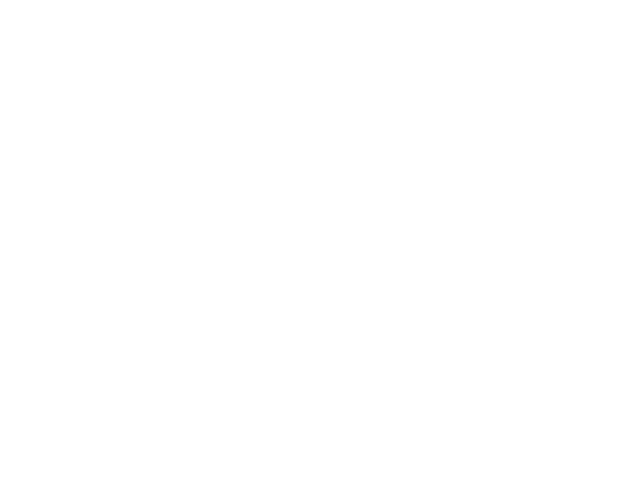

In [6]:
%matplotlib notebook
H_val = 7.83e3
st_state.plot_energy(
    film_inst.l1.Ms, film_inst.l2.Ms,
    H_val, phi_val,
    film_inst,
    N=5000
)

In [7]:
vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

np.arange(len(farmers))

array([0, 1, 2, 3, 4, 5, 6])

<IPython.core.display.Javascript object>


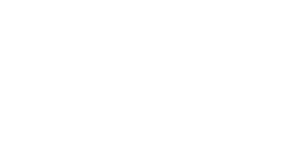

In [8]:
%matplotlib notebook
N = 1000
H_val = 7.83e3
tet_ang = np.linspace(0., 2*np.pi, N)
Ev_fr_ang = st_state.Ev1_lamb(
    film_inst.l1.Ms, tet_ang,
    H_val, phi_val,
    film_inst.l1.Hkeff
)
f = (film_inst.l1.Hkeff - 2*np.pi*film_inst.l1.Ms**2)*np.sin(tet_ang)**2 + 2*np.pi*film_inst.l1.Ms**2
s = -H_val*film_inst.l1.Ms*np.cos(tet_ang - phi_val)
plt.plot(np.rad2deg(tet_ang), f)
plt.plot(np.rad2deg(tet_ang), s)
plt.plot(np.rad2deg(tet_ang), Ev_fr_ang)
plt.grid()



<IPython.core.display.Javascript object>


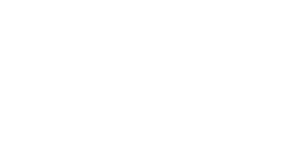

47.207207207207205


In [9]:
%matplotlib notebook
ang1 = np.linspace(0., 2*np.pi, 1000)
ang2 = np.deg2rad(47.1)

H_val = 9e3
Es_fr_ang1 = st_state.Es_lamb(
    film_inst.l1.Ms, film_inst.l2.Ms,
    H_val, phi_val,
    film_inst.l1.t, film_inst.l2.t,
    film_inst.l1.Hkeff, film_inst.l2.Hkeff, film_inst.J,
    ang1, ang2
)

plt.plot(np.rad2deg(ang1), film_inst.l1.t*((film_inst.l1.Hkeff - 2*np.pi*film_inst.l1.Ms**2)*np.sin(ang1)**2 + 2*np.pi*film_inst.l1.Ms**2), label="SW+demag")
plt.plot(np.rad2deg(ang1), -film_inst.l1.t*H_val*film_inst.l1.Ms*np.cos(ang1 - phi_val), label="zeeman")
plt.plot(np.rad2deg(ang1), film_inst.J*np.cos(ang1-ang2), label="exchange")
plt.plot(np.rad2deg(ang1), Es_fr_ang1, label="total")
plt.scatter(np.rad2deg(ang2), 0.0, color='black')
plt.scatter(np.rad2deg(ang2+np.pi), 0.0, color='red')
#plt.scatter(np.rad2deg(ang2-np.pi), 0.0, color='red')
plt.legend()
plt.grid(True)
print(np.rad2deg(ang1[Es_fr_ang1.argmin()]))


In [5]:
class StacionaryState2:
    def __init__(self):
        S = CoordSys3D('S')
        Mx1, My1, Mz1 = symbols("M_x1 M_y1 M_z1")
        Mx2, My2, Mz2 = symbols("M_x2 M_y2 M_z2")
        M1 = Mx1*S.i + My1*S.j + Mz1*S.k
        M2 = Mx2*S.i + My2*S.j + Mz2*S.k
        
        Hx, Hy, Hz = symbols("H_x H_y H_z")
        H = Hx*S.i + Hy*S.j + Hz*S.k
        
        Ku1, Ku2, J = symbols("K_u1 K_u2 J")
        t1, t2 = symbols("t1 t2")
        
        self.Ze1 = -H.dot(M1)
        self.Ze2 = -H.dot(M2)
        
        self.SW_D1 = Ku1*(Mx1**2 + My1**2)/(Mx1**2 + My1**2 + Mz1**2) + 2*sym.pi*(Mz1**2)
        self.SW_D2 = Ku2*(Mx2**2 + My2**2)/(Mx2**2 + My2**2 + Mz2**2) + 2*sym.pi*(Mz2**2)
        
        self.Ev1 = self.Ze1 + self.SW_D1
        self.Ev2 = self.Ze2 + self.SW_D2
        
        self.Es = J*M1.dot(M2)/(M1.magnitude()*M2.magnitude()) + t1*self.Ev1 + t2*self.Ev2
        
        
        
        Ze1_varset = (
            Mx1, My1, Mz1,
            Hx, Hy, Hz
        )
        self.Ze1_lamb = lambdify(Ze1_varset, self.Ze1, 'numpy')
        
        Ze2_varset = (
            Mx2, My2, Mz2,
            Hx, Hy, Hz
        )
        self.Ze2_lamb = lambdify(Ze2_varset, self.Ze2, 'numpy')
        
        
        
        SW_D1_varset = (
            Mx1, My1, Mz1,
            Ku1
        )
        self.SW_D1_lamb = lambdify(SW_D1_varset, self.SW_D1, 'numpy')
        
        SW_D2_varset = (
            Mx2, My2, Mz2,
            Ku2
        )
        self.SW_D2_lamb = lambdify(SW_D2_varset, self.SW_D2, 'numpy')
        
        
        Ev1_varset = (
            Mx1, My1, Mz1,
            Hx, Hy, Hz,
            Ku1
        )
        
        self.Ev1_lamb = lambdify(Ev1_varset, self.Ev1, 'numpy')
        
        Ev2_varset = (
            Mx2, My2, Mz2,
            Hx, Hy, Hz,
            Ku2
        )
        
        self.Ev2_lamb = lambdify(Ev2_varset, self.Ev2, 'numpy')
        
        
        Es_varset = (
            Mx1, My1, Mz1,
            Mx2, My2, Mz2,
            Hx, Hy, Hz,
            Ku1, Ku2,
            J,
            t1, t2
        )
        
        self.Es_lamb = lambdify(Es_varset, self.Es, 'numpy')
    
    
    def get_stationary_angles(
        self,
        H_val, phi_val,
        Ku1, Ku2,
        J,
        t1, t2
    ):  
        func_l = lambda x: self.funcmin(
            x, 
            H_val, phi_val,
            Ku1, Ku2,
            J,
            t1, t2
        )
        
        res_f = 0
        min_E = 1e10
        for i in range(100):
            res = optimize.minimize(func_l, 
                                    x0=np.random.uniform(size=(4,))*np.array([np.pi, 2*np.pi, np.pi, 2*np.pi]), 
                                    bounds=[(0,np.pi),(0,2*np.pi),(0,np.pi),(0,2*np.pi)], 
                                    tol=1e-14)
            if funcmin(res.x)<min_E:
                res_f = res
                min_E = funcmin(res.x)
        
        return res_f.x
    
        
    def funcmin(
        self, x, 
        H_val, phi_val,
        Ku1, Ku2,
        J,
        t1, t2
    ):
        tet1 = x[0]
        phi1 = x[1]
        M1 = pol2cart(film_inst.l1.Ms, tet1, phi1)
    
        tet2 = x[2]
        phi2 = x[3]
        M2 = pol2cart(film_inst.l2.Ms, tet2, phi2)
        
        H0 = pol2cart(H_val, phi_val, 0.)
        return st_state2.Es_lamb(
            M1[0], M1[1], M1[2],
            M2[0], M2[1], M2[2],
            H0[0], H0[1], H0[2],
            film_inst.l1.Hkeff, film_inst.l2.Hkeff,
            film_inst.J,
            film_inst.l1.t, film_inst.l2.t        
        )
        
    
st_state2 = StacionaryState2()
        
        

In [20]:
%matplotlib notebook

def pol2cart(r, tet, phi):
    x = r*np.sin(tet)*np.cos(phi)
    y = r*np.sin(tet)*np.sin(phi)
    z = r*np.cos(tet)
    return np.array([x,y,z])



ang1 = np.linspace(0., 2*np.pi, 1000)
#ang2 = np.deg2rad(47.1)
ang2 = np.deg2rad(47.0919)

M10 = pol2cart(film_inst.l1.Ms, ang1, 0.)
M20 = pol2cart(film_inst.l2.Ms, ang2, 0.)
H0 = pol2cart(H_val, phi_val, 0.)



H_val = 9.0e3
Es_fr_ang1 = st_state2.Es_lamb(
    M10[0], M10[1], M10[2],
    M20[0], M20[1], M20[2],
    H0[0], H0[1], H0[2],
    film_inst.l1.Hkeff, film_inst.l2.Hkeff,
    film_inst.J,
    film_inst.l1.t, film_inst.l2.t        
)

plt.plot(np.rad2deg(ang1), film_inst.l1.t*((film_inst.l1.Hkeff - 2*np.pi*film_inst.l1.Ms**2)*np.sin(ang1)**2 + 2*np.pi*film_inst.l1.Ms**2), label="SW+demag")
plt.plot(np.rad2deg(ang1), -film_inst.l1.t*H_val*film_inst.l1.Ms*np.cos(ang1 - phi_val), label="zeeman")
plt.plot(np.rad2deg(ang1), film_inst.J*np.cos(ang1-ang2), label="exchange")
plt.plot(np.rad2deg(ang1), Es_fr_ang1, label="total")
plt.scatter(np.rad2deg(ang2), 0.0, color='black', label='fixed M position')
plt.scatter(np.rad2deg(ang2+np.pi), 0.0, color='red')
#plt.scatter(np.rad2deg(ang2-np.pi), 0.0, color='red')

print(np.rad2deg(ang1[Es_fr_ang1.argmin()]))
plt.scatter(np.rad2deg(ang1[Es_fr_ang1.argmin()]),Es_fr_ang1[Es_fr_ang1.argmin()],label='optimal',color='b')
plt.legend()
plt.grid(True)
plt.title("H={}, tet1 = {}".format(H_val, np.rad2deg(ang2)))
plt.ylabel("E_surface")

47.207207207207205


Text(0, 0.5, 'E_surface')

In [12]:
%matplotlib notebook
from scipy import optimize


def pol2cart(r, tet, phi):
    x = r*np.sin(tet)*np.cos(phi)
    y = r*np.sin(tet)*np.sin(phi)
    z = r*np.cos(tet)
    return np.array([x,y,z])


H_val=7.0e3
def funcmin(x):
    tet1 = x[0]
    phi1 = x[1]
    M1 = pol2cart(film_inst.l1.Ms, tet1, phi1)
    
    tet2 = x[2]
    phi2 = x[3]
    M2 = pol2cart(film_inst.l2.Ms, tet2, phi2)
    
    H0 = pol2cart(H_val, phi_val, 0.)
    return st_state2.Es_lamb(
        M1[0], M1[1], M1[2],
        M2[0], M2[1], M2[2],
        H0[0], H0[1], H0[2],
        film_inst.l1.Hkeff, film_inst.l2.Hkeff,
        film_inst.J,
        film_inst.l1.t, film_inst.l2.t        
    )

res_f = 0
min_E = 1e10
for i in range(100):
    res = optimize.minimize(funcmin, 
                            x0=np.random.uniform(size=(4,))*np.array([np.pi, 2*np.pi, np.pi, 2*np.pi]), 
                            bounds=[(0,np.pi),(0,2*np.pi),(0,np.pi),(0,2*np.pi)], 
                            tol=1e-14)
    if funcmin(res.x)<min_E:
        res_f = res
        min_E = funcmin(res.x)
    
    

print(res_f)
print(np.rad2deg(res_f.x))


      fun: 2.4956146838594537
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.77635684e-07, -8.88178425e-08,  2.22044606e-07,  8.88178420e-08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 215
      nit: 14
     njev: 43
   status: 0
  success: True
        x: array([0.29354994, 6.28318531, 2.0571242 , 0.        ])
[ 16.81917243 360.         117.86453467   0.        ]


In [18]:
res = st_state2.get_stationary_angles(
    H_val, phi_val,
    film_inst.l1.Hkeff, film_inst.l2.Hkeff,
    film_inst.J,
    film_inst.l1.t, film_inst.l2.t
)

np.rad2deg(res)

array([117.86453476, 360.        ,  16.81917271,   0.        ])

In [13]:
def sm():
    a = def ss(): return 1.
    print(a())

sm()

SyntaxError: invalid syntax (<ipython-input-13-db7cab99b963>, line 2)

In [22]:
N = 36
tet1 = np.linspace(0, np.pi, N)
tet2 = np.linspace(0, np.pi, N)
phi1 = np.linspace(0, 2*np.pi, N)
phi2 = np.linspace(0, 2*np.pi, N)

Es_fr_angs = np.zeros((N,N,N,N))

H_val = 9e3
for i in range(N):
    for j in range(N):
        for k in range(N):
            for p in range(N):
                M1 = pol2cart(film_inst.l1.Ms, tet1[i], phi1[j])
                M2 = pol2cart(film_inst.l2.Ms, tet2[k], phi2[p])
                H0 = pol2cart(H_val, phi_val, 0.)
                Es_fr_angs[i][j][k][p] = st_state2.Es_lamb(
                    M1[0], M1[1], M1[2],
                    M2[0], M2[1], M2[2],
                    H0[0], H0[1], H0[2],
                    film_inst.l1.Hkeff, film_inst.l2.Hkeff,
                    film_inst.J,
                    film_inst.l1.t, film_inst.l2.t        
                )
                

print(np.unravel_index(Es_fr_angs.argmin(), Es_fr_angs.shape))

(9, 0, 9, 0)


In [22]:
from IPython.core.display import display, HTML
%matplotlib qt

def pol2cart(r, tet, phi):
    x = r*np.sin(tet)*np.cos(phi)
    y = r*np.sin(tet)*np.sin(phi)
    z = r*np.cos(tet)
    return np.array([x,y,z])



ang1 = np.linspace(0., 2*np.pi, 1000)
#ang2 = np.deg2rad(47.1)
K = 20
ang2s = np.linspace(0, np.pi, K)

#fig, ax = plt.subplots(K + 1)
#fig.set_figheight(80)
#fig.set_figwidth(30)

for i in range(K):
    ang2 = ang2s[i]
    M10 = pol2cart(film_inst.l1.Ms, ang1, 0.)
    M20 = pol2cart(film_inst.l2.Ms, ang2, 0.)
    
    H_val = 9.0e3
    H0 = pol2cart(H_val, phi_val, 0.)
    Es_fr_ang1 = st_state2.Es_lamb(
        M10[0], M10[1], M10[2],
        M20[0], M20[1], M20[2],
        H0[0], H0[1], H0[2],
        film_inst.l1.Hkeff, film_inst.l2.Hkeff,
        film_inst.J,
        film_inst.l1.t, film_inst.l2.t        
    )

    
    plt.plot(np.rad2deg(ang1),Es_fr_ang1, label=str(np.rad2deg(ang2)))
    print(np.rad2deg(ang1[Es_fr_ang1.argmin()]))

plt.legend()
plt.grid()
plt.title("H={}".format(H_val))
display(HTML("<style>.container { width:100% !important; }</style>"))

83.96396396396395
81.08108108108107
74.95495495495494
65.58558558558558
55.49549549549549
46.846846846846844
40.0
34.59459459459459
30.63063063063063
27.747747747747745
25.945945945945944
24.864864864864863
24.504504504504503
24.504504504504503
25.225225225225223
26.306306306306304
28.108108108108105
29.54954954954955
31.71171171171171
33.87387387387387


In [23]:
st_state2.Es


J*(M_x1*M_x2 + M_y1*M_y2 + M_z1*M_z2)/(sqrt(M_x1**2 + M_y1**2 + M_z1**2)*sqrt(M_x2**2 + M_y2**2 + M_z2**2)) + t1*(-H_x*M_x1 - H_y*M_y1 - H_z*M_z1 + K_u1*(M_x1**2 + M_y1**2)/(M_x1**2 + M_y1**2 + M_z1**2) + 2*pi*M_z1**2) + t2*(-H_x*M_x2 - H_y*M_y2 - H_z*M_z2 + K_u2*(M_x2**2 + M_y2**2)/(M_x2**2 + M_y2**2 + M_z2**2) + 2*pi*M_z2**2)